<a href="https://colab.research.google.com/github/khobzaoui/CNN-based-Side-Channel-Attack/blob/main/kyber_sca_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN training Starts...
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7637 - loss: 0.4911 - val_accuracy: 0.8520 - val_loss: 0.3510
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8584 - loss: 0.3342 - val_accuracy: 0.8480 - val_loss: 0.3545
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8611 - loss: 0.3177 - val_accuracy: 0.8485 - val_loss: 0.3562
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8606 - loss: 0.3158 - val_accuracy: 0.8505 - val_loss: 0.3489
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8611 - loss: 0.3096 - val_accuracy: 0.8540 - val_loss: 0.3478
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8698 - loss: 0.2974 - val_accuracy: 0.8450 - val_loss: 0.3545
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8771 - loss: 0.2886 - val_accuracy: 0.8480 - val_loss: 0.3642
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8797 - lo

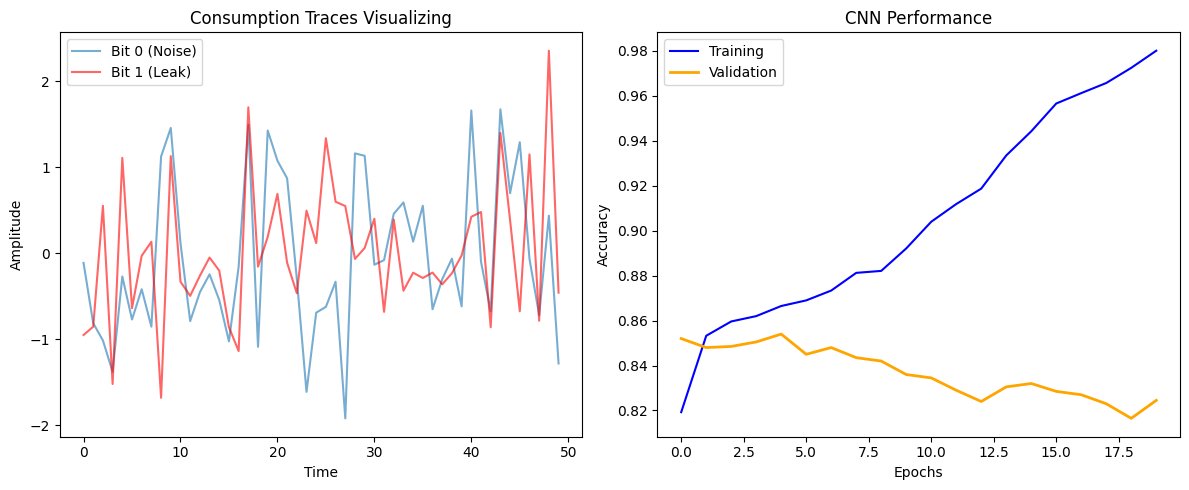

CPA Accuracy: 63.44%

[RESULT] CNN Accuracy : 82.45%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
# ==========================================
# 1. DATASET DESCRIPTION
# ==========================================
n_traces = 10000  # Dataset of 10k traces
points_par_trace = 50
labels = np.random.randint(0, 2, n_traces)

# Simulation of traces with noise gaussien
traces = np.random.normal(0, 0.8, (n_traces, points_par_trace))

for i in range(n_traces):
    if labels[i] == 1:
       # Simulated Point of Interest (PoI)
        traces[i, 25:28] += 1.0

    # Reshape for CNN
X = traces.reshape((n_traces, points_par_trace, 1))
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
# ==========================================
# 2. ANALYSE CPA
# ==========================================

correlations = np.zeros(points_par_trace)
for i in range(points_par_trace):
    correlations[i], _ = pearsonr(traces[:, i], labels)

# --- CPA ACCURACY  ---
# The accuracy of the CPA is estimated based on the maximum correlation peak.
# In real attack, the accuracy of CPA is proportional to the correlation.
max_corr = np.max(np.abs(correlations))
acc_cpa_calculated = 0.5 + (max_corr * 0.25) # Statistique estimation  of CPA performance

# ==========================================
# 2. CNN ARCHITECTURE
# ==========================================
model = Sequential([
    Input(shape=(points_par_trace, 1)),

    # Convolutional Layers
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),

    MaxPooling1D(pool_size=2),

    Flatten(),

    # Dense Layers
    Dense(100, activation='relu'),
    Dropout(0.2),  # To avoid overfitting
    Dense(100, activation='relu'),

    # Output : Binary Classification  (0 or 1)
    Dense(1, activation='sigmoid')
])

# Compilation with Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ==========================================
# 3. Training
# ==========================================
print("CNN training Starts...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# ==========================================
# 4. RESULTS VISUALISATION
# ==========================================
plt.figure(figsize=(12, 5))

# Left graph: Visualization of the leak
plt.subplot(1, 2, 1)
plt.plot(traces[labels == 0][0], label="Bit 0 (Noise)", alpha=0.6)
plt.plot(traces[labels == 1][0], label="Bit 1 (Leak)", color='red', alpha=0.6)
plt.title("Consumption Traces Visualizing")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Right graph: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)
plt.title("CNN Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
print(f"CPA Accuracy: {acc_cpa_calculated*100:.2f}%")
# Final Result
final_acc = history.history['val_accuracy'][-1]
print(f"\n[RESULT] CNN Accuracy : {final_acc * 100:.2f}%")